# Simulations 1

This notebook will involve no direct teaching - instead we are going to attempt to solve a number of difficult problems. These problems will attempt to range over a number of inter-disciplinary fields. Don't worry if you are not able to complete them all within the time of the workshop - they are meant to stretch your abilities, gain some useful NumPy experience and grow some inter-disciplinary knowledge. For these tasks we require that you **only** use NumPy arrays as this is considerably faster and the only tractable method in later examples.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tasks

## Monte Carlo Integration

*Monte Carlo methods* rely primarily on repeated sampling to obtain numerical results, and are used extensively in any application that involves a probabilistic interpretation. They are particularly powerful in *high-dimensional* problems where deterministic methods for high dimensions become intractable. They are often coupled with other techniques such as **Markov Chains** once the probability distribution of a variable is parameterized.

Let's say we have a mathematical function that is difficult to integrate:

$$
f(x)=\sin^2 \left(\frac{1}{x(2-x)}\right)
$$

to see this, do a quick plot.

We see that the infinite oscillation as $f(x)$ draws towards 0 and 2 makes this function incredibly difficult to integrate using standard numerical methods (composite trapezoidal, simpsons).

However we can make use of the fact that this function is *bounded* at [0, 2], and **scatter** a large uniform random distribution $\cal N[0, 1]$ across this box. The fraction of them falling below the curve is approximately the integral we want to compute; hence:

$$
I=\int_a^b f(x) \ dx \quad \implies \quad I \simeq \frac{k A}{N}
$$

where $N$ is the total number of points considered, $k$ is the number falling below the curve, and $A$ is the area of the box. We know that $x \in [0, 2]$, and we choose $y \in [0, 1]$, giving $A=(y_1-y_0)(x_1-x_0)$.

### Task 1

Write a function `monte_carlo_integrate()` which receives the function $f(x)$, the domain of $x$, the domain of $y$, and $N$. It should compute the integral of `f(x)` using the Monte Carlo method. Remember that the random numbers generated *must* be scaled into the domains of $x$ and $y$.

In [2]:
# write codes here
def monte_carlo_integrate(f, dx, dy, N):
    area = (dx[1] - dx[0])*(dy[1] - dy[0])
    # generate random numbers in 2-d
    pairs = np.random.rand(N,2)
    # move pairs into domain [x,y]
    pairs[:,0] *= dx[1] - dx[0]
    pairs[:,0] += dx[0]
    pairs[:,1] *= dy[1] - dy[0]
    pairs[:,1] += dy[0]
    # x is in [:,0]
    integrand = f(pairs[:,0])
    # choose k where random numbers y fall below the integrand
    k = pairs[:,1] < integrand

    return (area * np.sum(k)) / N 

### Task 2

Call `monte_carlo_integrate()` with the function described above, with $x \in [0, 2]$, $y \in [0, 1]$, and $N=10^5$. Is it reasonable?

In [4]:
# write codes here
def f(x):
    return np.sin(1/(x*(2-x)))**2

I = monte_carlo_integrate(f, [0, 2], [0, 1], 10**5)
print(I)

1.44688



### Task 3

The area of a circle of radius 2 is $4\pi$. To help check the accuracy, let's calculate $\pi$ by calculating the area of a *quarter-circle* in $x,y \in [0, 2]$:

$$
\pi = \int_0^2 \sqrt{4-x^2} \ dx
$$

Repeat calls to `monte_carlo_integrate()` and generate integrals of Monte-Carlo integration with $N$. We recommend using $N=100 \times 2^i$ for $i=0,\dots,15$.

In [5]:
# write codes here
def pi(x):
	return np.sqrt(4-x**2)

Nvals = 100*2**np.arange(0,15)
errs = np.zeros((15,))

for i, N in enumerate(Nvals):
	errs[i] = abs(monte_carlo_integrate(pi, [0, 2], [0, 2], N ) - np.pi)

### Task 4

Generate the loglog plot of $N$ against $E$, also known as the **convergence** of the algorithm, where:

$$
E= \lvert \pi-\hat \pi \rvert
$$

where $\hat \pi = I$ integral from our Monte-Carlo method.

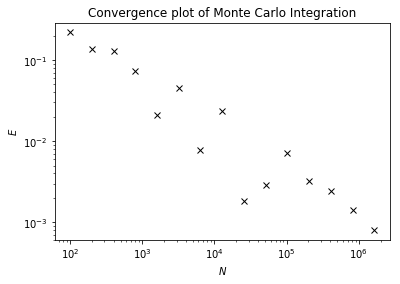

In [12]:
# write codes here
plt.loglog(Nvals, errs, 'kx')
plt.xlabel(r"$N$")
plt.ylabel(r"$E$")
plt.title("Convergence plot of Monte Carlo Integration")
plt.show()

### Task 5

The coefficients for the slope ($m$) and intercept ($b$) can be calculated with `np.polyfit(N,E,1)`, remember to pass the $\log N$ and $\log E$! Plot the slope line through the points using loglog, using $y=mx+b$ for the $y$ variables. However given that the plot is in logspace, we calculate $y$ as:

$$
y=\exp(b)N^m
$$

Calculate and plot the slope of the plot.

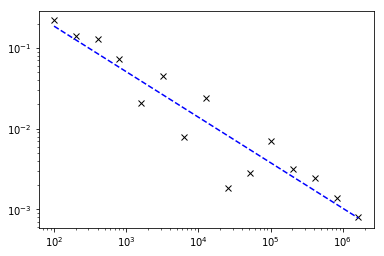

In [13]:
# write codes here
plt.loglog(Nvals, errs, 'kx')
m,b = np.polyfit(np.log(Nvals), np.log(errs), 1)
plt.loglog(Nvals, np.exp(b)*Nvals**m, 'b--')
plt.show()

## Ising Model

The Ising Model is a simplified two-dimensional representation of a magnet. A regular, square, $N \times N$ lattice represents the sites which have individual magnetic *spins*, which are $\pm 1$: so $S_{ij}$ is the spin at site $(i,j)$. The total energy of the magnet is given by the sum of the nearest-neighbour interaction energies:

$$
E=-J \sum_{i,j=0}^{N-1}\left(S_{i-1,j}+S_{i+1,j}+S_{i,j-1}+S_{i,j+1} \right)
$$

where $J$ is the strength of the interaction which we will set to $1$ throughout. Period boundaries are used for the magnet:

$$
S_{-1,j}=S_{N-1,j}, \\
S_{N,j}=S_{0,j}, \\
S_{i,-1}=S_{i,N-1}, \\
S_{i,N}=S_{i,0}
$$

If the spin of one site $(i,j)$ is flipped then the energy change is:

$$
\Delta_E=2J S_{ij} \left(S_{i-1,j}+S_{i+1,j}+S_{i,j-1}+S_{i,j+1} \right)
$$

The total (average) magnetization is:

$$
M=\frac{1}{N^2} \sum_{i,j=0}^{N-1} S_{ij}
$$

This model can be effective solved using the **Metropolis-Hastings** algorithm. 

The Metropolis-Hastings algorithm starts from the assumption that the ground state will try to minimize its energy. Therefore the samples $n_j$ with energy $E_j$ is "better" than the samples $n_i$ with energy $E_i$ if $E_j<E_i$.

However, the rule to only accept a transition from samples with high energy to samples with low energy doesn't match detailed balance. There must be some chance of moving to a state with higher energy. This probability must match the qualitative form of the overall distribution. If we make the assumption that the energies follow the Boltzmann distribution, then the chance of a state appearing with $E_j>E_i$ is $∼\exp[−\beta(E_j−E_i)]$, where $\beta$ is $k_BT$ ($k_B$ is the Boltzmann constant and $T$ the temperature of the system).

### Task 1

Write a function, `calc_positional_e()`, which accepts a 2-D matrix of magnetic spins with $J$, and factoring in periodic boundaries, **only** calculates the sum of the nearest-neighbour interactions.

**NOTE**: There are a few strategies to do this; but a naive approach which uses native Python `for` loops will not be effective when we scale up. You will need to deploy some performance-boosting method such as `Cython` or `jit` if you take that route.

In [14]:
from numba import jit

In [15]:
@jit(nopython=True)
def calc_positional_e(spins, J):
    """
    In this strategy, we use pure Python and beef up our code with JIT or Cython.
    """
    N = spins.shape[0]
    E = np.zeros_like(spins)
    # for loop
    for i in range(N):
        for j in range(N):
            if i == 0:
                spin_l = spins[N-1,j]
                spin_r = spins[i+1,j]
            elif i == N-1:
                spin_l = spins[i-1,j]
                spin_r = spins[0,j]
            else:
                spin_l = spins[i,j-1]
                spin_r = spins[i,j+1]
                
            if j == 0:
                spin_u = spins[i,N-1]
                spin_d = spins[i,j+1]
            elif j == N-1:
                spin_u = spins[i,j-1]
                spin_d = spins[i,0]
            else:
                spin_u = spins[i,j-1]
                spin_d = spins[i,j+1]
                
            E[i,j] = spin_l + spin_r + spin_u + spin_d
    return E

### Task 2

Write a function, `delta_e()`, which calculates the change in energy at site $(i,j$), accepting a 2-D matrix as a parameter (subset of the whole magnet), with $i$, $j$, and $J$. Test your method with a couple of random magnets and random indices, you should expect values in the range $-4 \lt x \lt 4$.

In [16]:
@jit
def delta_e(spins, i, j, J):
    N = spins.shape[0]
    # check boundaries first!
    if i == 0:
        spin_l = spins[N-1,j]
        spin_r = spins[i+1,j]
    elif i == N-1:
        spin_l = spins[i-1,j]
        spin_r = spins[0,j]
    else:
        spin_l = spins[i-1,j]
        spin_r = spins[i+1,j]

    if j == 0:
        spin_u = spins[i,N-1]
        spin_d = spins[i,j+1]
    elif j == N-1:
        spin_u = spins[i,j-1]
        spin_d = spins[i,0]
    else:
        spin_u = spins[i,j-1]
        spin_d = spins[i,j+1]
        
    return 2. * J * spins[i,j] * (spin_l+spin_r+spin_u+spin_d)

### Task 3

Write a function, `total_mag_e()`, which calculates the total magnetic energy of a 2-D matrix, given their magnetic spins and $J$.

In [17]:
def total_mag_e(spins, J):
    return -J*np.sum(calc_positional_e(spins, J))

### Task 4

Write the `metropolis_hastings()` algorithm, as described above, with parameters $N$, `n_steps` and $\beta$ using the following pseudocode as guidance:

    Set variable spins: numpy array of size N x N, with random -1/+1.
    Set variable J: 1
    Set variable E_series: empty numpy array of size `steps`
    Set the first step of E_series: as the total magnetic energy.
    For loop: increment step;
        Set random variable randx: U[0,N]
        Set random variable randy: U[0,N]
        Set variable delta_E: call function
        if delta_E < 0 or random variable U[0,1] < boltzmann distribution:
            Flip the spin at site [randx,randy]
            E_series[step] = E_series[step-1] + delta_E
        else:
            E_series[step] = E_series[step-1]
    Returns spins, E_series
    
where `randx` and `randy` are random variables drawn from an integer distribution between $0$ and $N$.

In [18]:
def metropolis_hastings(N, n_steps, beta):
    spins = np.random.choice([-1,1], size=(N,N))
    J = 1
    E_series = np.ones(n_steps)
    E_series[0] = total_mag_e(spins, J)
    
    for s in range(1, n_steps):
        randx = np.random.randint(N)
        randy = np.random.randint(N)
        # calculate de
        dE = delta_e(spins, randx, randy, J)
        # if we decrease the energy or meet boltzmann requirements, flip the spin
        if dE < 0. or np.exp(-beta*dE) > np.random.rand():
            spins[randx, randy] *= -1
            E_series[s] = E_series[s-1] + dE
        else:
            E_series[s] = E_series[s-1]
    return spins, E_series

### Task 5

Run the `metropolis_hastings()` algorithm with $N=40$, $\beta=0.1$ and $\beta=1$. Try using $2\times10^5$ iterations. Plot the resulting energy series returned from the function against the number of iterations.

In addition, plot the final state of each magnet, using each $\beta$ value, using `plt.imshow`.

In [19]:
A = metropolis_hastings(40, int(5*10**5), 0.1)
B = metropolis_hastings(40, int(5*10**5), 1.0)

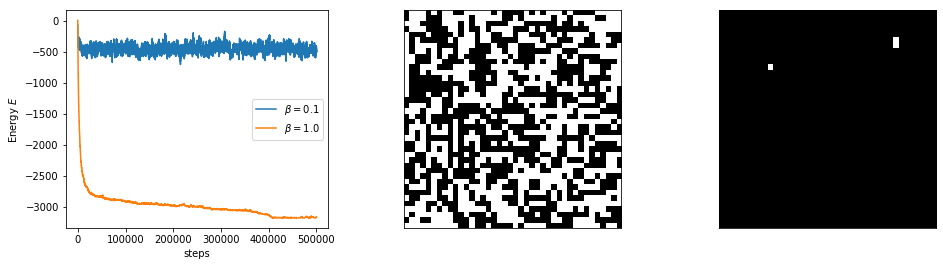

In [23]:
fig,ax=plt.subplots(ncols=3, figsize=(16,4))

ax[0].plot(A[1], label=r"$\beta=0.1$")
ax[0].plot(B[1], label=r"$\beta=1.0$")
ax[0].legend()
ax[1].imshow(A[0], cmap="gray")
ax[2].imshow(B[0], cmap='gray')

for a in [ax[1], ax[2]]:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)

ax[0].set_xlabel("steps")
ax[0].set_ylabel(r"Energy $E$")
plt.show()

### Task 6

Using a lattice of $20^2$ sites, and $5 \times 10^5$ steps, over $50$ different $\beta \in [0.1, 0.6]$, plot $\beta$ against the *average magnetization* (see function above!). What do you see happening to the magnet as $\beta$ increases?

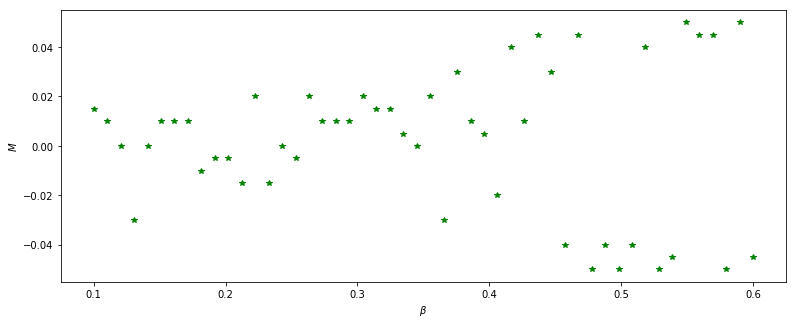

In [30]:
bvals = 50
betas = np.linspace(0.1, 0.6, bvals)
m_ser = np.zeros(bvals)

def average_magnetization(spins, N):
    return (1 / N**2) * np.sum(spins)

for b in range(bvals):
    # print("Running beta=%.4f" % betas[b])
    C, E = metropolis_hastings(20, 500000, betas[b])
    m_ser[b] = average_magnetization(C[0], 20)
    
# plot
fig = plt.figure(figsize=(13,5))
plt.plot(betas, m_ser, "g*")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$M$")
plt.show()

### Task 7 (Optional)

Try to find performance gains on your `metropolis_hastings()` algorithm by modifying the code, and using `%prun` to profile your function and see where the majority of time is spent.

Try to get gains by using **Cython** also.

In [24]:
%prun metropolis_hastings(40, 500000, 0.5)

         1980549 function calls in 2.640 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.361    1.361    2.640    2.640 <ipython-input-18-3e8b55ae57e0>:1(metropolis_hastings)
   999998    1.076    0.000    1.076    0.000 {method 'randint' of 'mtrand.RandomState' objects}
   499999    0.135    0.000    0.135    0.000 <ipython-input-16-dad24200fa89>:1(delta_e)
   480535    0.067    0.000    0.067    0.000 {method 'rand' of 'mtrand.RandomState' objects}
        1    0.001    0.001    0.001    0.001 {built-in method numpy.core.multiarray.copyto}
        1    0.000    0.000    0.000    0.000 {method 'choice' of 'mtrand.RandomState' objects}
        2    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    2.640    2.640 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 <ipython-input-17-c6ed9bd7c7bd>:1(total_mag_e)
        1    0.000

In [25]:
%timeit metropolis_hastings(40, 500000, 0.5)

1.85 s ± 53.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%load_ext Cython

In [27]:
%%cython

import numpy as np
cimport numpy as np
cimport cython

from libc.math cimport exp

cdef extern from "stdlib.h":
    double drand48()
    void srand48(long int seedval)
    
cdef extern from "time.h":
    long int time(int)


@cython.boundscheck(False)
@cython.wraparound(False)
cdef double calc_positional_e(np.ndarray[np.int_t, ndim=2] spins, int i, int j, double J):
    """
    In this strategy, we use pure Python and beef up our code with JIT or Cython.
    """
    cdef:
        int N
        double spin_l, spin_r, spin_u, spin_d
    
    N = spins.shape[0]
    
    if i == 0:
        spin_l = spins[N-1,j]
        spin_r = spins[i+1,j]
    elif i == N-1:
        spin_l = spins[i-1,j]
        spin_r = spins[0,j]
    else:
        spin_l = spins[i,j-1]
        spin_r = spins[i,j+1]

    if j == 0:
        spin_u = spins[i,N-1]
        spin_d = spins[i,j+1]
    elif j == N-1:
        spin_u = spins[i,j-1]
        spin_d = spins[i,0]
    else:
        spin_u = spins[i,j-1]
        spin_d = spins[i,j+1]

    return spin_l + spin_r + spin_u + spin_d


@cython.boundscheck(False)
@cython.wraparound(False)
cdef double delta_e(np.ndarray[np.int_t, ndim=2] spins, int i, int j, double J):
    return 2.0 * J * spins[i,j] * calc_positional_e(spins, i, j, J)


cdef double total_mag_e(np.ndarray[np.int_t, ndim=2] spins, double J):  
    cdef:
        int i, j, N
        double sum_sp
        
    N = spins.shape[0]
    sum_sp = 0
    for i in range(N):
        for j in range(N):
            sum_sp += (calc_positional_e(spins, i, j, J))
            
    return -J*sum_sp


@cython.boundscheck(False)
@cython.wraparound(False)
def metropolis_hastings2(int N, int n_steps, double beta):
    # declare
    cdef:
        int s, randx, randy
        double J, dE
        np.ndarray[np.float_t, ndim=1] E_series = np.ones(n_steps)
        np.ndarray[np.int_t, ndim=2] spins = np.random.choice([-1,1], size=(N,N))

    srand48(123456789)
    J = 1.0
    E_series[0] = total_mag_e(spins, J)
    
    for s in range(1, n_steps):
        randx = int(drand48() * N)
        randy = int(drand48() * N)
        # calculate de
        dE = delta_e(spins, randx, randy, J)
        # if we decrease the energy or meet boltzmann requirements, flip the spin
        if dE < 0. or exp(-beta*dE) > drand48():
            spins[randx, randy] *= -1
            E_series[s] = E_series[s-1] + dE
        else:
            E_series[s] = E_series[s-1]
    return spins, E_series

In [28]:
%timeit metropolis_hastings2(40, 500000, 0.5)

255 ms ± 3.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


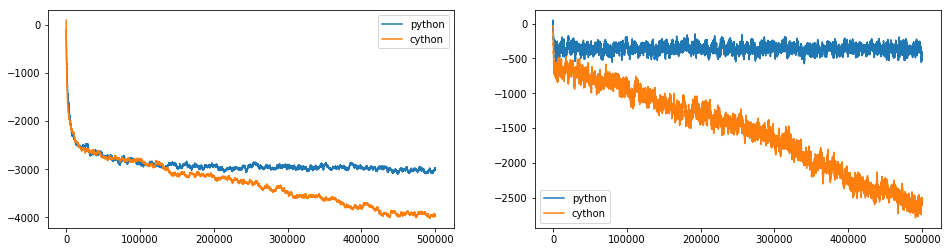

In [29]:
C1, E1 = metropolis_hastings(40, 500000, .6)
C2, E2 = metropolis_hastings2(40, 500000, .6)
C3, E3 = metropolis_hastings(40, 500000, .1)
C4, E4 = metropolis_hastings2(40, 500000, .1)
fig,ax=plt.subplots(ncols=2, figsize=(16,4))

ax[0].plot(E1, label=r"python")
ax[0].plot(E2, label="cython")
ax[0].legend()
ax[1].plot(E3, label=r"python")
ax[1].plot(E4, label="cython")
ax[1].legend()